In [1]:
#Packages
import h5py
import os
import numpy as np    
import matplotlib.pyplot as plt
from scipy.constants import pi
from scipy.optimize import curve_fit as fit
import func as func
import random
from tqdm import tqdm

### Plotting 3D:

In [ ]:
#Directory with data:
datadir = "G2-lcdm-gas/"

files = os.listdir(datadir+".")
files.sort()
for file in files:    #Importing data (Particle Type 1 - dark matter, Particle Type 2 - baryonic matter):
    f = h5py.File(datadir+file, "r")
    group = f["PartType0"]
    data = group["Coordinates"][()]
    dens = group["Density"][()]
    
    #Plotting the initial conditions of both galaxies:
    fig = plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    plot = ax.scatter3D(data[:,0],data[:,1],data[:,2],'k.',s=0.5,c=dens,cmap="jet",alpha=0.1)
    cbar = fig.colorbar(plot, ax = ax)
    cbar.set_label('Density', rotation=0)
    plt.show()

### Distances to one particle:

In [4]:
datadir = "G2-lcdm-gas/"
files = os.listdir(datadir+".")
files.sort()

f = h5py.File(datadir+"snapshot_004.hdf5", "r")
group = f["PartType0"]
data = group["Coordinates"][()]
dmax=np.sqrt(3)*50000

hist=[]
hist=np.array(hist)

part=30000     #Number of particles to loop distances:

for j in tqdm(range(part)):
    d=[]
    for i in range(1,len(data)):
        r=func.distance(data[j,0],data[i,0],data[j,1],data[i,1],data[j,2],data[i,2])
        d=np.append(d,r)
    output=np.histogram(d,bins=100,range=(0,dmax))
    counts=output[0]
    n=np.array(counts)
    hist=np.concatenate((hist,counts),axis=0)
hist=np.split(hist,part)

100%|██████████| 30000/30000 [10:37:22<00:00,  1.27s/it]      


### Random particle generation inside cube of 50000 kpc

In [5]:
# Number of particles involved in randomization:
n = 32700

# Setting limits for each coordinate:
x1, x2 = 0, 50000
y1, y2 = 0, 50000
z1, z2 = 0, 50000

# Defining the final coordinate vectors randomly:
x = (x2 - x1)*np.random.rand(n) + x1
y = (y2 - y1)*np.random.rand(n) + y1
z = (z2 - z1)*np.random.rand(n) + z1

# Same measuring block as before, histogram making looping each particle:
dmax=np.sqrt(3)*50000

histrand=[]
histrand=np.array(histrand)
 
for j in tqdm(range(part)):
    d=[]
    for i in range(1,len(x)):
        r=func.distance(x[j],x[i],y[j],y[i],z[j],z[i])
        d=np.append(d,r)
    output=np.histogram(d,bins=100,range=(0,dmax))
    counts=output[0]
    n=np.array(counts)
    histrand=np.concatenate((histrand,counts),axis=0)
histrand=np.split(histrand,part)
np.savetxt("histrand.txt", histrand, delimiter =", ")

  0%|          | 25/30000 [00:12<4:17:18,  1.94it/s]


KeyboardInterrupt: 

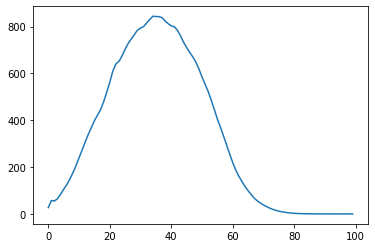

In [6]:
histogram=np.average(hist,axis=0)
histogramrand=np.average(histrand,axis=0)
plt.plot(histogram)

In [7]:
np.savetxt("histogram.txt", histogram, delimiter =", ")


0.8059959770082348
rm: cannot remove 'SphereIC.hdf5': No such file or directory


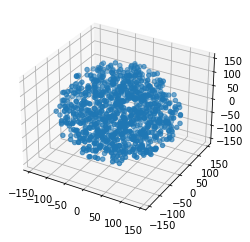

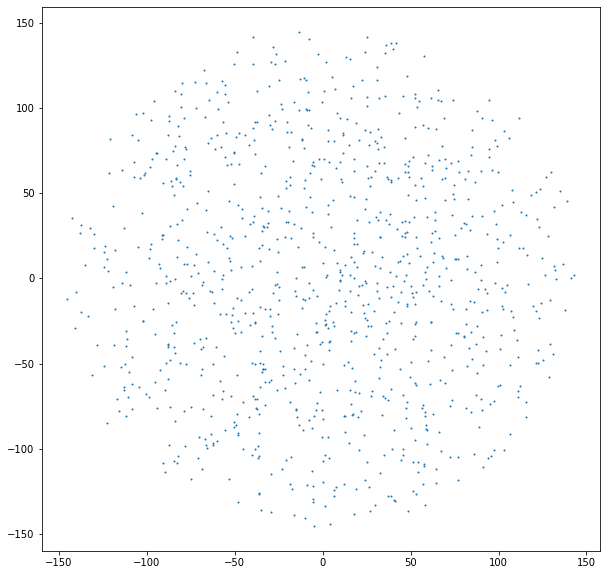

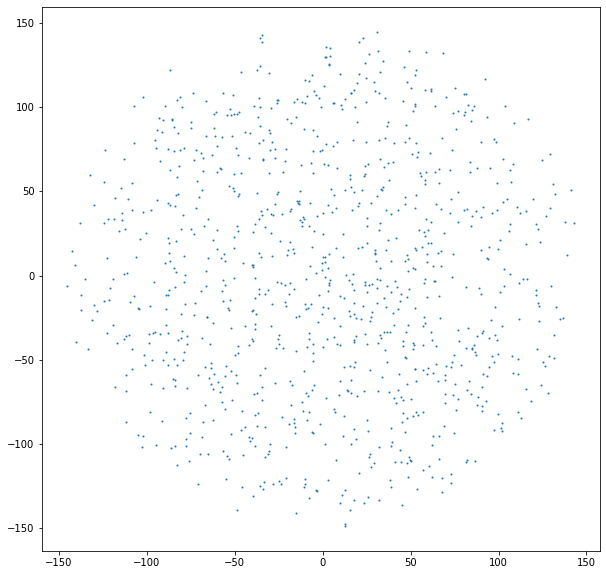

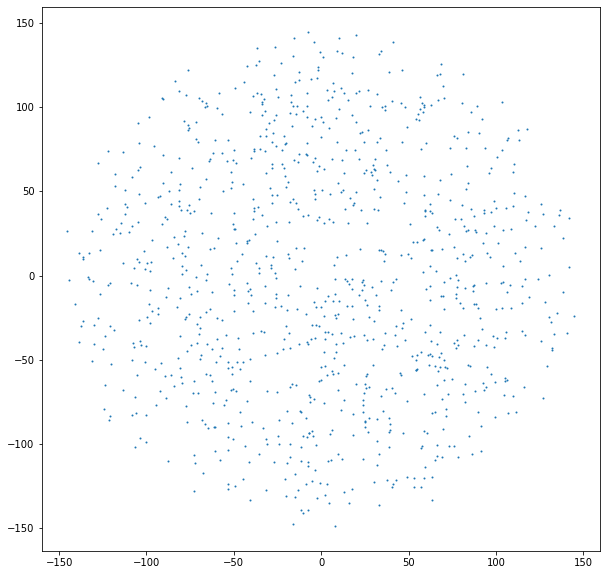

In [6]:
#Create Distribution

import random
import numpy as np

random.seed(77)

npart = 1000
Mtotal = 1e+12 #10e4msun
rmax = 150 #kpc
Vtot = 4*np.pi*(rmax**3)/3 #kpc^3
n = npart/(Vtot) #kpc^-3
meanlen = (1/n)**(1/3) #kpc

soft = meanlen/30
print(soft)

sall = 1

phi = np.random.uniform(0,2*np.pi,npart)
costheta = np.random.uniform(-1,1,npart)
u = np.random.uniform(0,1,npart)

theta = np.arccos( costheta )
r = rmax *u**(1/3)

x = r * np.sin( theta) * np.cos( phi )
y = r * np.sin( theta) * np.sin( phi )
z = r * np.cos( theta )

ID = np.linspace(1,npart,npart,dtype = int)

#Check uniformity
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)

plt.figure(figsize=(10,10))
plt.scatter(x,y,s=sall)
plt.figure(figsize=(10,10))
plt.scatter(x,z,s=sall)
plt.figure(figsize=(10,10))
plt.scatter(y,z,s=sall)

x.shape = (npart,1)
y.shape = (npart,1)
z.shape = (npart,1)
Coordinates = np.concatenate((x,y,z),axis = 1)
Velocities = np.zeros_like(Coordinates)

#Create hdf5

import h5py
import sys

filename = 'SphereIC.hdf5'

!rm SphereIC.hdf5
#Create File
file = h5py.File(filename,'w')

#Create Group
header = file.create_group("Header")
PartType1 = file.create_group("PartType1")

coordsDSET = file.create_dataset("/PartType1/Coordinates", (npart,3), dtype =  h5py.h5t.IEEE_F32LE)
IDsDSET = file.create_dataset("/PartType1/ParticleIDs", (npart,), dtype =   h5py.h5t.STD_U32LE)
velsDSET = file.create_dataset("/PartType1/Velocities", (npart,3), dtype =  h5py.h5t.IEEE_F32LE)

coordsDSET[...] = Coordinates
IDsDSET[...] = ID
velsDSET[...] = Velocities


nparts = np.zeros(3)
nparts[1] = npart
header.attrs['NumPart_ThisFile']    = nparts

massvec = np.zeros(3)
massvec[1] = Mtotal/npart

header.attrs['MassTable']           = massvec
header.attrs['Time']                = 0
header.attrs['Redshift']            = 15
header.attrs['NumPart_Total']       = nparts
header.attrs['NumFilesPerSnapshot'] = 1
header.attrs['BoxSize']             = 1.0
header.attrs['Omega0']              = 1.0
header.attrs['OmegaLambdda']        = 0.
header.attrs['HubbleParam']         = 0.7
header.attrs['Flag_Entropy_ICs']    = 0
header.attrs['NumPart_Total_HighWord'] = np.zeros(3)


# Close the file before exiting
#
file.close()